In [0]:
import pandas as pd
import numpy as np
from google.colab import drive
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def rmse(logY_pred,logY_act):
    rms = sqrt(mean_squared_error(logY_pred, logY_act))
    return rms

import original data

In [0]:
#without ProviderID and VendorID
X_train = pd.read_csv('drive/My Drive/Colab Notebooks/Data/train_data_hhp1.csv')
X_year_2 = X_train
X_test = pd.read_csv('drive/My Drive/Colab Notebooks/Data/test_data_hhp1.csv')
X_train, X_validation = train_test_split(X_train, test_size=0.3, random_state=0)

Y_train = X_train['DaysInHospital']
Y_test = X_test['DaysInHospital']
Y_validation = X_validation['DaysInHospital']

X_train.drop(['DaysInHospital', 'Year', 'ClaimsTruncated', 'MemberID'], axis=1, inplace=True)
X_test.drop(['DaysInHospital', 'Year', 'ClaimsTruncated', 'MemberID'], axis=1, inplace=True)
X_validation.drop(['DaysInHospital', 'Year', 'ClaimsTruncated', 'MemberID'], axis=1, inplace=True)

X_year_2.drop(['DaysInHospital','Year','ClaimsTruncated','MemberID'], axis=1, inplace=True)

Scale input

In [9]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
col_name = X_train.columns

X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
X_validation_scaled = sc.transform(X_validation)
X_year_2_scaled = sc.transform(X_year_2)

#add features name
X_year_2_scaled = pd.DataFrame(X_year_2_scaled , columns=col_name)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=col_name)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col_name)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=col_name)

X_train_scaled.head()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,age_05,age_15,age_25,age_35,age_45,age_55,age_65,age_75,age_85,age_MISS,...,DrugCountMin,DrugCountMax,DrugCountMean,DrugCount,labCount_min,labCount_max,labCount_ave,labcount_months,labNull,drugNull
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.142857,0.285714,0.250000,1.000000,0.0,0.0,0.00,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.285714,0.714286,0.500000,0.166667,0.2,0.2,0.20,0.083333,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.2,0.5,0.35,0.166667,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.7,0.7,0.70,0.083333,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142857,0.142857,0.142857,0.166667,0.0,0.0,0.00,0.000000,0.0,0.0


Convert output to log scale

In [0]:
logYtrain = np.log(Y_train+1)
logYtest = np.log(Y_test+1)
logYvalidation = np.log(Y_validation+1)

Training - predict

In [0]:
#Initialize LGBM
gbm_regr = LGBMRegressor(objective='regression', 
                     boosting_type='dart', 
                     metric='rmse',
                     n_estimators=4500,
                     num_leaves=30, 
                     learning_rate=0.005, 
                     bagging_fraction=0.9,
                     feature_fraction=0.3,
                     bagging_seed=0,
                     max_depth=6,
                     reg_alpha=0.436193,
                     reg_lambda=0.479169,
                     colsample_bytree=0.508716,
                     min_split_gain=0.024766,
                    )

In [0]:
GBMregr = gbm_regr.fit(X_train_scaled ,logYtrain)

Evaluate model

In [0]:
logY_pred_test = gbm_regr.predict(X_test_scaled, num_iteration= gbm_regr.best_iteration_)
logY_pred_validation = gbm_regr.predict(X_validation_scaled, num_iteration= gbm_regr.best_iteration_)

logY_pred_train = gbm_regr.predict(X_train_scaled, num_iteration= gbm_regr.best_iteration_)

#RMSLE after truncated
#truncated output
logY_pred_test[logY_pred_test < 0] = 0
logY_pred_train[logY_pred_train < 0] = 0
logY_pred_validation[logY_pred_validation < 0] = 0

print('error on training set: ', rmse(logYtrain, logY_pred_train),
     'error on validation set: ', rmse(logYvalidation, logY_pred_validation),
      'error on testing set: ', rmse(logYtest, logY_pred_test)
    )

In [0]:
logY2_pred = gbm_regr.predict(X_year_2, num_iteration= gbm_regr.best_iteration_)
logY2_pred[logY2_pred < 0] = 0
Y2_pred = np.exp(logY2_pred)
Y3_pred = np.exp(logY_pred_test)

Y2_pred = pd.DataFrame(Y2_pred, columns=['Y_pred_LGBM_scaled1'])
Y3_pred = pd.DataFrame(Y3_pred, columns=['Y_pred_LGBM_scaled1'])
#Y_pred_validation= pd.DataFrame(Y_pred_validation, columns=['Y_pred_LGBM'])

pd.DataFrame(Y2_pred).to_csv("drive/My Drive/Colab Notebooks/Data/Y2_pred_LGBM1.csv", encoding='utf-8')
#pd.DataFrame(Y_pred_validation).to_csv("Data/Y_pred_validation_LGBM.csv", encoding='utf-8')
pd.DataFrame(Y3_pred).to_csv("drive/My Drive/Colab Notebooks/Data/Y3_pred_LGBM1.csv", encoding='utf-8')

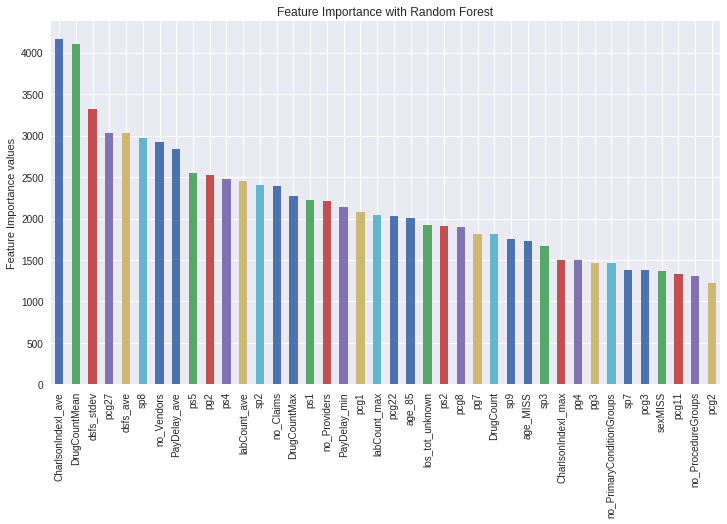

In [0]:
# Plot the top 20 important features
imp_feat_rf = pd.Series(gbm_regr.feature_importances_, index=X_train_scaled.columns).sort_values(ascending=False)
imp_feat_rf[:40].plot(kind='bar', title='Feature Importance with Random Forest', figsize=(12,8))
plt.ylabel('Feature Importance values')
plt.subplots_adjust(bottom=0.25)
plt.savefig('FeatImportance.png')
plt.show()

In [0]:
#remove all features with 0 important value
list1 = list()
for indx, val in imp_feat_rf.iteritems():
  #print(indx,val)
  if val==0:
    list1.append(indx)

In [0]:
list1

['pcg42', 'pcg45', 'no_PCPs', 'labNull', 'drugNull']

In [0]:
X_train_scaled.drop(list1, axis=1, inplace=True)
X_validation_scaled.drop(list1, axis=1, inplace=True)
X_test_scaled.drop(list1, axis=1, inplace=True)

In [0]:
gbm_regr.fit(X_train_scaled, logYtrain)

In [0]:
logY_pred_test = gbm_regr.predict(X_test_scaled, num_iteration=gbm_regr.best_iteration_)
logY_pred_validation = gbm_regr.predict(X_validation_scaled, num_iteration=gbm_regr.best_iteration_)

logY_pred_train = gbm_regr.predict(X_train_scaled, num_iteration=gbm_regr.best_iteration_)

print('error on training set: ', rmsle(logYtrain, logY_pred_train),
     'error on validation set: ', rmsle(logYvalidation, logY_pred_validation),
      'error on testing set: ', rmsle(logYtest, logY_pred_test)
    )

In [0]:
#RMSLE after truncated
#truncated output
logY_pred_test[logY_pred_test < 0] = 0
logY_pred_train[logY_pred_train < 0] = 0
logY_pred_validation[logY_pred_validation < 0] = 0

print('error on training set: ', rmsle(logYtrain, logY_pred_train),
     'error on validation set: ', rmsle(logYvalidation, logY_pred_validation),
      'error on testing set: ', rmsle(logYtest, logY_pred_test)
    )

In [0]:
logY2_pred = gbm_regr.predict(X_year_2_scaled, num_iteration= gbm_regr.best_iteration_)
logY2_pred[logY2_pred < 0] = 0

logY2_pred = pd.DataFrame(logY2_pred, columns=['Y_pred_LGBM'])
logY3_pred = pd.DataFrame(logY_pred_test, columns=['Y_pred_LGBM'])

pd.DataFrame(logY2_pred).to_csv("drive/My Drive/Colab Notebooks/Data/Y2_pred_LGBM_scaled.csv", encoding='utf-8')
pd.DataFrame(logY3_pred).to_csv("drive/My Drive/Colab Notebooks/Data/Y3_pred_LGBM_scaled.csv", encoding='utf-8')